This notebook shows how to plots the active tasks from downloaded Tez dag.

First upload the downloaded dag to the Jupyter file in Home tab.

In [ ]:
list.of.packages <- c("ggplot2", "RCurl", "rjson","knitr","markdown","jsonlite")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos='http://cran.us.r-project.org')
lapply(list.of.packages,function(x){library(x,character.only=TRUE)}) 


In [4]:
readzip <- function(zipfile) {
    # Create a name for the dir where we'll unzip
    zipdir <- tempfile()
    # Create the dir using that name
    dir.create(zipdir)
    # Unzip the file into the dir
    unzip(zipfile, exdir=zipdir)
    # Get the files into the dir
    allfiles <- list.files(zipdir)
    # Throw an error if there's more than one
    if(length(allfiles)<1) stop("No data file inside zip")
    # Get the full name of the file
    task_files=allfiles[grepl("tasks_part_.*.json",allfiles)]
    wd=getwd()
    setwd(zipdir)
    tasks <- list()
    #https://cran.r-project.org/web/packages/jsonlite/vignettes/json-paging.html
    for(i in 1:length(task_files)){
      mydata <- fromJSON(task_files[i])
      message("Retrieving file tasks_part_", i)
      tasks[[i+1]] <- mydata$tasks
    }
    setwd(wd)
    all_tasks <- rbind.pages(tasks)
}

# This is useful for plotting downloaded ZIP
plotTezZip <- function(dag,title="Tez plot" , interval=1000, xtick=100, ytick=100,savefile="tezdag"){
	range=length(dag$otherinfo$status)
	vertex = unique(matrix(unlist(strsplit(dag$entity,"_")),ncol = 6, byrow=T)[,5]) #help from https://stat.ethz.ch/pipermail/r-help/2010-January/224852.html
	# task_1446542009204_0186_1_05_000552
	tasks=data.frame(time=rep(0,range),total=rep(0,range))
	count=1	
	for (i in seq(from=min(dag$otherinfo$startTime)-1, to=max(dag$otherinfo$endTime)+interval, by=interval)){
		tasks[count,"time"]=count
		tasks[count,"total"]=length(which(dag$otherinfo$startTime < i & dag$otherinfo$endTime > (i+interval) ))
		for (j in 1:length(vertex)) {
			tasks[count,paste("task_",vertex[j],sep="")]=length(which(grepl(paste("_",vertex[j],"_",sep=""),dag$entity) & dag$otherinfo$startTime < i & dag$otherinfo$endTime > (i+interval) ))	
		}
		count=count+1
	}

	library(reshape2) 
	data2 <- melt(tasks, id = "time")
	p = ggplot(data2, aes(x = time, y = value, color = variable)) + geom_line() + theme(legend.title=element_blank()) + scale_x_continuous(minor_breaks = round(seq(0, length(tasks$time), by = xtick),1)) + scale_y_continuous(minor_breaks = round(seq(0, max(tasks$total)*1.1, by = ytick),1)) +xlab(paste("Time (",interval, " ms)")) + ylab("Number of Tasks") +ggtitle(title)
	if(hasArg(savefile)){
		ggsave(plot=p,file=savefile)
		print(sprintf("Saved plot as %s",savefile))
	}
	p
}


Retrieving file tasks_part_1
Warning message:
: Removed 1232 rows containing missing values (geom_path).

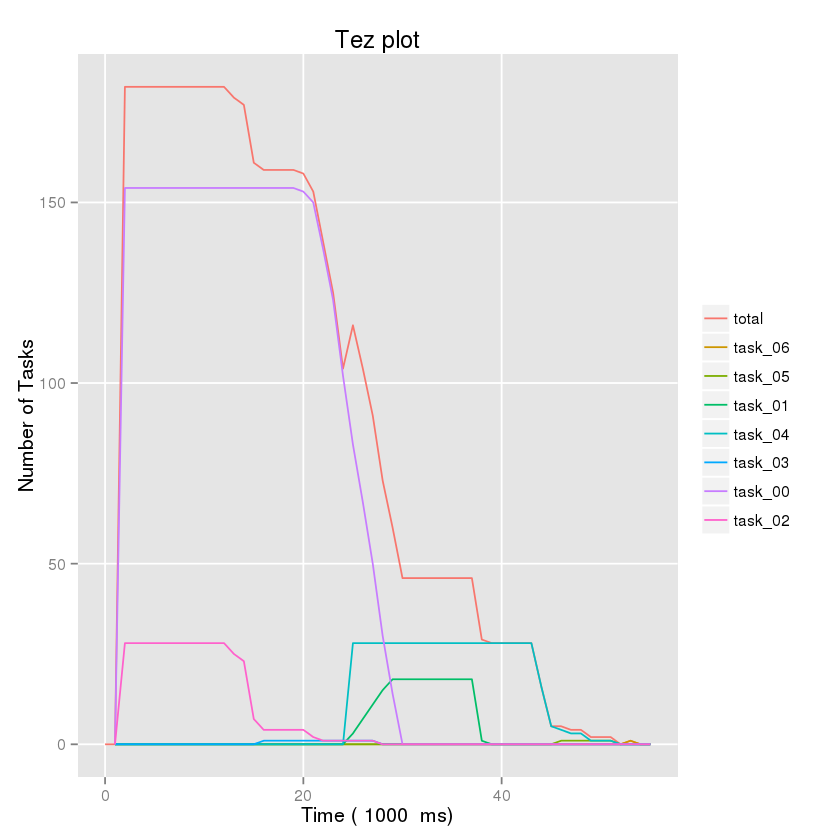

In [5]:
plotTezZip(readzip('dag_1467076665878_0018_1.zip'))